In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from copy import deepcopy
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    a = int(float(a))
    b = int(b)
    if a > 0.0:
        return r'${0:d}\times 10^{{{1}}}$'.format(a, b)
    elif a < 0.0:
        return r'${0:d}\times 10^{{{1}}}$'.format(a, b)
    elif a ==0.0:
        return r'0'

In [2]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/*.fits')
print(infiles)

['/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/R21_S00_R21_S00_17.0_crosstalk_matrix.fits', '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/R21_S01_R21_S01_17.0_crosstalk_matrix.fits', '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/R21_S02_R21_S02_17.0_crosstalk_matrix.fits', '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/R21_S10_R21_S10_17.0_crosstalk_matrix.fits', '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/R21_S11_R21_S11_17.0_crosstalk_matrix.fits', '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/R21_S12_R21_S12_17.0_crosstalk_matrix.fits', '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/R21_S20_R21_S20_17.0_crosstalk_matrix.fits', '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/R21_S21_R21_S21_17.0_crosstalk_matrix.fits', '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_

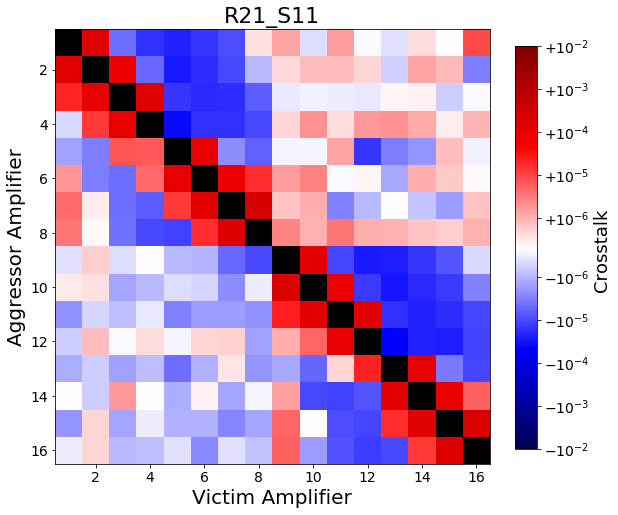

In [45]:
infile = infiles[4]
binned_cmap = False

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

## Binned colormap
if binned_cmap:
    cmap = plt.cm.seismic
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    cmap.set_bad(color='black')
    
    bounds = np.asarray([-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-1.0E-6, 1.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2])
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    cbar_ticks = [-5.0E-3,-5.0E-4,-5.0E-5,-5.0E-6, 0., 5.0E-6, 5.0E-5, 5.0E-4, 5.0E-3]
    cbar_ticklabels = [r'$-10^{-3}$', r'$-10^{-4}$', r'$-10^{-5}$', r'$-10^{-6}$', '0',
                       r'$+10^{-6}$', r'$+10^{-5}$', r'$+10^{-4}$', r'$+10^{-3}$']
    
else:
    cmap = plt.cm.seismic
    cmap.set_bad(color='black')
    norm = colors.SymLogNorm(1E-6, vmin=-1.E-2, vmax=1E-2)
    cbar_ticks = [-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-1.0E-6, 1.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2]
    cbar_ticklabels = [r'$-10^{-2}$', r'$-10^{-3}$', r'$-10^{-4}$', r'$-10^{-5}$', r'$-10^{-6}$',
                        r'$+10^{-6}$', r'$+10^{-5}$', r'$+10^{-4}$', r'$+10^{-3}$', r'$+10^{-2}$']
                        
with fits.open(infile) as hdulist:
    xtalk = hdulist[1].data
    agg_amp = hdulist[0].header['AGGRESSOR']
np.fill_diagonal(xtalk, np.nan)

im = ax.imshow(xtalk, norm=norm, cmap=cmap, interpolation='none', extent=(0.5, 16.5, 16.5, 0.5))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Aggressor Amplifier', fontsize=20)
ax.set_xlabel('Victim Amplifier', fontsize=20)
ax.set_title('{0}'.format(agg_amp), fontsize=22)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                    ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticklabels)
cbar.set_label("Crosstalk ", size=18)
cbar.ax.tick_params(labelsize=14)

# Single Raft Cross Talk Results

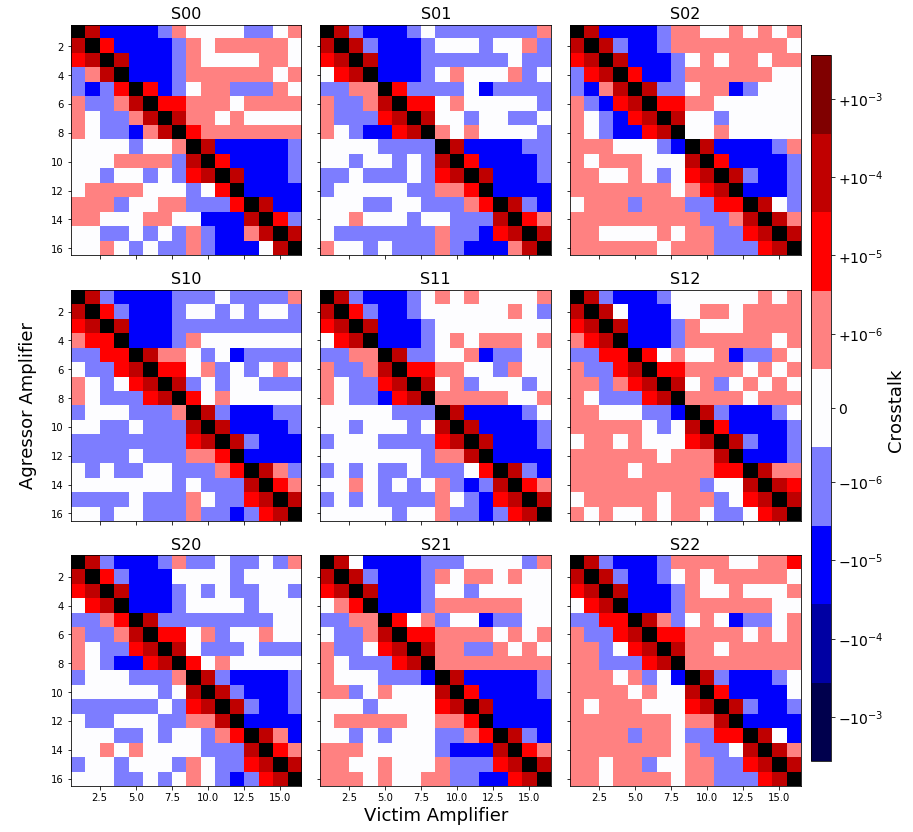

In [87]:
## Get raft results
raft_id = 'R21'
binned_cmap = True
full_matrix = False

sensor_list = ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22']

results_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6813D_xtalk/new_results/'

## Binned colormap
if binned_cmap:
    cmap = plt.cm.seismic
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    cmap.set_bad(color='black')
    
    bounds = np.asarray([-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-1.0E-6, 1.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2])
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    cbar_ticks = [-5.0E-3,-5.0E-4,-5.0E-5,-5.0E-6, 0., 5.0E-6, 5.0E-5, 5.0E-4, 5.0E-3]
    cbar_ticklabels = [r'$-10^{-3}$', r'$-10^{-4}$', r'$-10^{-5}$', r'$-10^{-6}$', '0',
                       r'$+10^{-6}$', r'$+10^{-5}$', r'$+10^{-4}$', r'$+10^{-3}$']
    
else:
    cmap = plt.cm.seismic
    cmap.set_bad(color='black')
    norm = colors.SymLogNorm(1E-6, vmin=-1.E-2, vmax=1E-2)
    cbar_ticks = [-1.0E-2, -1.0E-3,-1.0E-4,-1.0E-5,-1.0E-6, 1.0E-6, 1.0E-5, 1.0E-4, 1.0E-3, 1.0E-2]
    cbar_ticklabels = [r'$-10^{-2}$', r'$-10^{-3}$', r'$-10^{-4}$', r'$-10^{-5}$', r'$-10^{-6}$',
                        r'$+10^{-6}$', r'$+10^{-5}$', r'$+10^{-4}$', r'$+10^{-3}$', r'$+10^{-2}$']

## Plot 
if full_matrix:
    fig, ax = plt.subplots(1,1, figsize=(14, 12))
    
    raft_xtalk = np.full((9*16, 9*16), 0.0)
    for i, sensor_id in enumerate(sensor_list):

        for j, sensor_id2 in enumerate(sensor_list):

            try:
                crosstalk_results = os.path.join(results_dir,
                                                 '{0}_{1}_{0}_{2}_17.0_crosstalk_matrix.fits'.format(raft_id, sensor_id, sensor_id2))
                with fits.open(crosstalk_results) as hdulist:
                    xtalk = hdulist[1].data
            except:
                continue

            raft_xtalk[i*16:(i+1)*16, j*16:(j+1)*16] = xtalk

    np.fill_diagonal(raft_xtalk, np.nan)

    im1 = ax.imshow(raft_xtalk, norm=norm, cmap=cmap, interpolation='none')

    ## Add lines to differentiate CCD regions
    for i in range(8):
        ax.axvline(x=15.5+16*i, color='dimgray')
    for i in range(8):
        ax.axhline(y=15.5+16*i, color='dimgray')

    ## Set up binned colorbar
    cbar = fig.colorbar(im1,  ax=ax, orientation='vertical', 
                        ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_ticklabels)
    cbar.set_label("Cross Talk", size=18)
    cbar.ax.tick_params(labelsize=14)

    ## Label by CCD
    labels = ('S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22')
    ax.set_xticks([7.5+16*i for i in range(9)])
    ax.set_yticks([7.5+16*i for i in range(9)])
    ax.set_xticklabels(labels, {'fontsize':14})
    ax.set_yticklabels(labels, {'fontsize':14})

    ax.set_ylabel('Aggressor Amplifier', fontsize=18)
    ax.set_xlabel('Victim Amplifier', fontsize=18)
    ax.set_title('{0} Crosstalk Matrix'.format(raft_id), fontsize=22)
    
else:
    
    fig, axes = plt.subplots(3, 3, figsize=(14, 14), sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.15, wspace=-.2)
    axes = axes.flatten()
    
    for i, sensor_id in enumerate(sensor_list):

        try:
            crosstalk_results = os.path.join(results_dir,
                                             '{0}_{1}_{0}_{1}_17.0_crosstalk_matrix.fits'.format(raft_id, sensor_id))
            with fits.open(crosstalk_results) as hdulist:
                xtalk = hdulist[1].data
        except:
            continue

        np.fill_diagonal(xtalk, np.nan)

        im = axes[i].imshow(xtalk, norm=norm, cmap=cmap, interpolation='none', extent=(0.5, 16.5, 16.5, 0.5))
        axes[i].set_title('{0}'.format(sensor_id), fontsize=16)

    fig.subplots_adjust(right=0.93)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                        ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_ticklabels)
    cbar.set_label("Crosstalk ", size=18)
    cbar.ax.tick_params(labelsize=14)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, 
                    left=False, right=False)
    plt.ylabel('Agressor Amplifier', fontsize=18, labelpad=-30)
    plt.xlabel('Victim Amplifier', fontsize=18)